## Import libraries


In [1]:
import math

import matplotlib.pyplot as plt
import torch
from torch import nn

## Time Distributed


In [2]:
class TimeDistributed(nn.Module):
    """
    A wrapper to apply any module (e.g., nn.Linear, nn.Conv) independently
    across each timestep of a sequence.

    Input shape:
        If batch_first=True:  (batch, time, features)
        Else:                 (time, batch, features)

    Output shape:
        Matches input, except the last dimension changes to the module's output size.
    """

    def __init__(self, module, batch_first=True):
        """
        Args:
            module (nn.Module): The layer to apply at each timestep.
            batch_first (bool): If True, input is (batch, time, features).
                                If False, input is (time, batch, features).
        """
        super().__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        # If input has no time dimension, apply module directly
        if len(x.size()) <= 2:
            return self.module(x)

        # Flatten batch and time into one dimension
        # Example: (batch=32, time=10, features=8) → (320, 8)
        x_reshape = x.contiguous().view(-1, x.size(-1))

        # Apply the wrapped module (e.g., Linear) to every timestep
        y = self.module(x_reshape)

        # Reshape back to (batch, time, output_size) or (time, batch, output_size)
        if self.batch_first:
            y = y.contiguous().view(
                x.size(0), -1, y.size(-1)
            )  # (batch, time, output_size)
        else:
            y = y.contiguous().view(
                x.size(0), x.size(1), y.size(-1)
            )  # (time, batch, output_size)

        return y

In [3]:
# Example
x = torch.randn((32, 10, 6), dtype=torch.float)  # (batch, time, size)
print("Tensor shape:", x.shape)

td = TimeDistributed(nn.Linear(6, 64), batch_first=True)
y = td(x)

print("Output shape:", y.shape)

Tensor shape: torch.Size([32, 10, 6])
Output shape: torch.Size([32, 10, 64])


## Gated Linear Unit (GLU)


In [4]:
class GLU(nn.Module):
    """Gated Linear Unit for controlling information flow."""

    def __init__(self, input_size: int):
        super().__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.fc2 = nn.Linear(input_size, input_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of GLU.

        Args:
            x (Tensor): Input tensor of shape (..., input_size).

        Returns:
            Tensor: Output tensor of shape (..., input_size).
        """
        gate = self.sigmoid(self.fc1(x))  # gating signal
        transformed = self.fc2(x)  # linear transformation
        return torch.mul(gate, transformed)  # element-wise gating

In [5]:
# Example
x = torch.randn((32, 10, 6), dtype=torch.float)  # (batch, time, size)
print("Tensor shape:", x.shape)

glu = GLU(6)
y = glu(x)

print("Output shape:", y.shape)

Tensor shape: torch.Size([32, 10, 6])
Output shape: torch.Size([32, 10, 6])


## Gated Residual Network (GRN)


In [6]:
class GatedResidualNetwork(nn.Module):
    """
    Gated Residual Network (GRN)

    A feed-forward block with:
    - Residual connections
    - Optional context input
    - Gating mechanism (GLU)
    - Normalization and dropout
    """

    def __init__(
        self,
        input_size,
        hidden_state_size,
        output_size,
        dropout,
        hidden_context_size=None,
        batch_first=True,
    ):
        """
        Args:
            input_size (int): Number of features in the input.
            hidden_state_size (int): Size of the hidden layer.
            output_size (int): Size of the output features.
            dropout (float): Dropout probability.
            hidden_context_size (int, optional): Size of context features (if provided).
            batch_first (bool): If True, input is (batch, time, features).
        """
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_state_size = hidden_state_size
        self.hidden_context_size = hidden_context_size

        # Residual shortcut if input and output sizes differ
        if self.input_size != self.output_size:
            self.skip_layer = TimeDistributed(
                nn.Linear(self.input_size, self.output_size), batch_first=batch_first
            )

        # First feed-forward layer
        self.fc1 = TimeDistributed(
            nn.Linear(self.input_size, self.hidden_state_size), batch_first=batch_first
        )
        self.elu = nn.ELU()

        # Optional context projection
        if self.hidden_context_size is not None:
            self.context = TimeDistributed(
                nn.Linear(self.hidden_context_size, self.hidden_state_size),
                batch_first=batch_first,
            )

        # Second feed-forward layer
        self.fc2 = TimeDistributed(
            nn.Linear(self.hidden_state_size, self.output_size), batch_first=batch_first
        )

        # Regularization and gating
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(self.output_size)
        self.gate = TimeDistributed(GLU(self.output_size), batch_first=batch_first)

    def forward(self, x, context=None):
        """
        Forward pass of GRN.

        Args:
            x (Tensor): Input tensor of shape (batch, time, input_size).
            context (Tensor, optional): Context tensor of shape
                                        (batch, time, hidden_context_size).
        Returns:
            Tensor: Output tensor of shape (batch, time, output_size).
        """
        # Residual connection
        if self.input_size != self.output_size:
            residual = self.skip_layer(x)
        else:
            residual = x

        # First transformation + optional context
        x = self.fc1(x)
        if context is not None:
            context = self.context(context)
            x = x + context
        x = self.elu(x)

        # Second transformation
        x = self.fc2(x)
        x = self.dropout(x)

        # Gating + residual + normalization
        x = self.gate(x)
        x = x + residual
        x = self.norm(x)

        return x

In [7]:
# Example
x = torch.randn((32, 10, 6), dtype=torch.float)  # (batch, time, size)
print("Tensor shape:", x.shape)

context = torch.randn((32, 10, 4))
print("Context shape:", context.shape)

grn = GatedResidualNetwork(
    input_size=6,
    hidden_state_size=16,
    output_size=8,
    dropout=0.1,
    hidden_context_size=4,
    batch_first=True,
)
y = grn(x)

print("Output shape:", y.shape)

Tensor shape: torch.Size([32, 10, 6])
Context shape: torch.Size([32, 10, 4])
Output shape: torch.Size([32, 10, 8])


## Variable Selection Network (VSN)


In [8]:
class VariableSelectionNetwork(nn.Module):
    """
    Variable Selection Network (VSN)

    Learns to assign weights to different input variables (features)
    and combines them into a single hidden representation.
    """

    def __init__(
        self,
        input_size,
        num_inputs,
        hidden_size,
        dropout,
        context=None,
        batch_first=True,
    ):
        """
        Args:
            input_size (int): Size of each individual input variable embedding.
            num_inputs (int): Number of input variables (features).
            hidden_size (int): Size of hidden layers.
            dropout (float): Dropout rate.
            context (int, optional): Context vector size (if used for conditioning).
        """
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_inputs = num_inputs
        self.dropout = dropout
        self.context = context
        self.batch_first = batch_first

        # GRN to produce variable selection weights (one per variable)
        if self.context is not None:
            self.flattened_grn = GatedResidualNetwork(
                self.num_inputs * self.input_size,
                self.hidden_size,
                self.num_inputs,
                self.dropout,
                self.context,
                self.batch_first,
            )
        else:
            self.flattened_grn = GatedResidualNetwork(
                self.num_inputs * self.input_size,
                self.hidden_size,
                self.num_inputs,
                self.dropout,
                batch_first=self.batch_first,
            )

        # One GRN per input variable to transform it
        self.single_variable_grns = nn.ModuleList()
        for i in range(self.num_inputs):
            self.single_variable_grns.append(
                GatedResidualNetwork(
                    self.input_size, self.hidden_size, self.hidden_size, self.dropout
                )
            )

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, embedding, context=None, variable_mask=None, valid_mask=None):
        """
        Forward pass.

        Args:
            embedding (Tensor): Input embeddings of shape [batch, time, num_inputs * input_size].
            context (Tensor, optional): Context vector for conditioning.
            variable_mask (Tensor, optional): Variable Mask [Batch, Time, Num_Inputs].
                                    1.0 for valid features, 0.0 for missing features.
            valid_mask (Tensor, optional): Padding Mask [Batch, Time].
                                           1.0 for valid timesteps, 0.0 for padding/invalid.

        Returns:
            outputs (Tensor): Combined variable representations [batch, time, hidden_size].
            sparse_weights (Tensor): Variable selection weights [batch, time, num_inputs, 1].
        """
        # Compute selection weights
        if context is not None:
            raw_scores = self.flattened_grn(embedding, context)
        else:
            raw_scores = self.flattened_grn(embedding)

        if variable_mask is not None:
            # We replace scores where mask == 0 with -1e9
            raw_scores = raw_scores.masked_fill(variable_mask == 0, -1e9)

        # Apply Softmax to get weights (0 to 1)
        sparse_weights = self.softmax(raw_scores).unsqueeze(-1)

        if valid_mask is not None:
            if valid_mask.ndim == sparse_weights.ndim - 2:
                # e.g. valid_mask (B, T), sparse_weights (B, T, Inputs, 1)
                expanded_mask = valid_mask.unsqueeze(-1).unsqueeze(-1)
            elif valid_mask.ndim == sparse_weights.ndim - 1:
                # e.g. valid_mask (B), sparse_weights (B, Inputs, 1)
                expanded_mask = valid_mask.unsqueeze(-1).unsqueeze(-1)
            else:
                expanded_mask = valid_mask

            # Force weights to 0.0 where valid_mask
            sparse_weights = sparse_weights * expanded_mask

        is_time_distributed = len(embedding.shape) == 3

        # Transform each variable separately
        var_outputs = []
        for i in range(self.num_inputs):
            var_slice = embedding[
                ..., (i * self.input_size) : (i + 1) * self.input_size
            ]
            var_outputs.append(self.single_variable_grns[i](var_slice))

        # Dynamic stacking and summing
        if is_time_distributed:
            stack_dim = 2
            sum_dim = 2
        else:
            stack_dim = 1
            sum_dim = 1

        # Stack transformed variables into one tensor
        var_outputs = torch.stack(var_outputs, dim=stack_dim)

        # Apply selection weights and combine
        outputs = var_outputs * sparse_weights
        outputs = outputs.sum(axis=sum_dim)

        return outputs, sparse_weights

In [9]:
# Example
vsn = VariableSelectionNetwork(
    input_size=4,  # embedding size per variable
    num_inputs=5,  # number of variables
    hidden_size=8,  # hidden size
    dropout=0.1,
    context=6,  # context vector size
    batch_first=True,
)

x = torch.randn(32, 10, 5 * 4)  # [batch, time, num_inputs * input_size]
context = torch.randn(32, 10, 6)  # [batch, time, context_size]
mask = torch.ones(32, 10, 5)
mask[:, :3, :3] = 0  # First 3 timesteps is invalid
mask[:, -1, :] = 0  # Last 1 timestep is invalid

out, weights = vsn(x, context, mask)

print("Output shape:", out.shape)
print("Context shape:", context.shape)
print("Weights shape:", weights.shape)

Output shape: torch.Size([32, 10, 8])
Context shape: torch.Size([32, 10, 6])
Weights shape: torch.Size([32, 10, 5, 1])


## Positional Encoder


In [10]:
class PositionalEncoder(nn.Module):
    """
    Adds sinusoidal positional encodings to input embeddings so the model
    can capture the order of timesteps.
    """

    def __init__(self, d_model: int, max_seq_len: int = 160, batch_first: bool = True):
        super().__init__()
        self.d_model = d_model
        self.batch_first = batch_first

        # Positional encoding matrix
        pe = torch.zeros(max_seq_len, d_model)
        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        # Calculate the encodings
        pe[:, 0::2] = torch.sin(position * div_term)  # For even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # For odd indices
        self.register_buffer("pe", pe.unsqueeze(0))  # shape: (1, max_seq_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Add positional encoding to input tensor.
        Args:
            x: Tensor of shape
               - (batch, seq_len, d_model) if batch_first=True
               - (seq_len, batch, d_model) if batch_first=False
        Returns:
            Tensor with same shape as input.
        """
        if self.batch_first:
            seq_len = x.size(1)
            x = x + self.pe[:, :seq_len, :]
        else:
            seq_len = x.size(0)
            x = x + self.pe[:, :seq_len, :].transpose(0, 1)
        return x

Tensor shape: torch.Size([32, 365, 64])
Output shape: torch.Size([32, 365, 64])


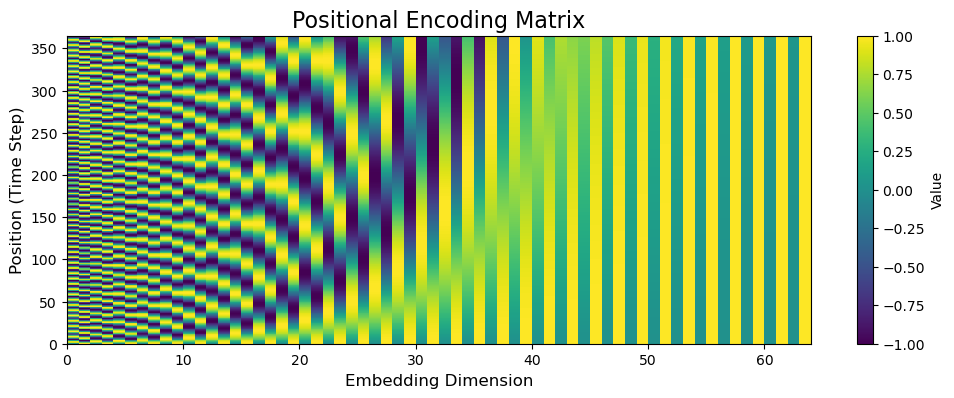

In [11]:
# Example
d_model = 64  # Dimension of the model embedding
max_seq_len = 365  # Maximum sequence length

x = torch.randn((32, max_seq_len, d_model), dtype=torch.float)  # (batch, time, size)
print("Tensor shape:", x.shape)

# Create Encoder and Get Embeddings
pos_encoder = PositionalEncoder(d_model=d_model, max_seq_len=max_seq_len)

y = pos_encoder(x)
print("Output shape:", y.shape)

# Extract the buffer for plotting
# Shape: (1, max_seq_len, d_model) -> (max_seq_len, d_model)
pe = pos_encoder.pe.squeeze(0).numpy()

# Plot the Positional Embeddings
fig, ax = plt.subplots(figsize=(12, 4))

# Use pcolormesh for a heatmap
cax = ax.pcolormesh(pe, cmap="viridis")
fig.colorbar(cax, label="Value")

ax.set_xlabel("Embedding Dimension", fontsize=12)
ax.set_ylabel("Position (Time Step)", fontsize=12)
ax.set_title("Positional Encoding Matrix", fontsize=16)

plt.show()

## Multi Head Pooling


In [12]:
class MultiHeadPooling(nn.Module):
    """
    Multi-head attention pooling with Vectorized Attention and
    Dynamic Pyramidal Fusion.
    """

    def __init__(self, input_dim, num_heads=4, dropout=0.1):
        super().__init__()
        self.num_heads = num_heads
        self.input_dim = input_dim

        # Outputs scores for ALL heads at once: (Batch, Time, Num_Heads)
        self.scoring_net = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.Tanh(),
            nn.Linear(input_dim // 2, num_heads),
        )

        # Dynamic Pyramidal Fusion Construction
        total_dim = input_dim * num_heads
        layers = []
        current_dim = total_dim

        # Automatically build layers: 4096 -> 2048 -> ... -> 256
        while current_dim > input_dim:
            next_dim = max(input_dim, current_dim // 2)

            layers.append(nn.Linear(current_dim, next_dim))

            # Add Norm/Act/Drop for all but the final projection
            if next_dim > input_dim:
                layers.append(nn.LayerNorm(next_dim))
                layers.append(nn.GELU())
                layers.append(nn.Dropout(dropout))

            current_dim = next_dim

        self.head_fusion = nn.Sequential(*layers)

    def forward(self, x, mask=None):
        """
        Args:
            x: (B, T, F)
            mask: (B, T) where True = padded timestep to ignore
        """
        # Compute scores for ALL heads in parallel
        # scores: (B, T, num_heads)
        scores = self.scoring_net(x)

        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(-1), -1e9)

        # Compute Attention Weights
        attn_weights = torch.softmax(scores, dim=1)  # (B, T, num_heads)

        # Vectorized Pooling
        # b=batch, t=time, h=heads, f=features
        # We sum over time (t)
        # Result: (B, num_heads, F)
        head_outputs = torch.einsum("bth,btf->bhf", attn_weights, x)

        # Flatten for Fusion
        # (B, num_heads, F) -> (B, num_heads * F)
        batch_size = x.size(0)
        combined = head_outputs.reshape(batch_size, -1)

        # Apply Pyramidal Fusion
        output = self.head_fusion(combined)  # (B, F)

        return output, attn_weights

In [13]:
# Test
B = 8  # batch instances
T = 10  # timesteps
F = 256  # features

x = torch.randn(B, T, F)

# Mask last 3 timesteps as padding
mask = torch.zeros(B, T, dtype=torch.bool)
mask[:, -3:] = True

model = MultiHeadPooling(input_dim=F, num_heads=8)

output, weights = model(x, mask)

print("Input shape:", x.shape)
print("Output shape:", output.shape)  # Expected: (B, F)
print("Weights shape:", weights.shape)  # Expected: (B, T, Num_Heads)

Input shape: torch.Size([8, 10, 256])
Output shape: torch.Size([8, 256])
Weights shape: torch.Size([8, 10, 8])


## CropFusionNet


In [ ]:
class CropFusionNet(nn.Module):
    """
    CropFusionNet: A deep learning model for end-season yield forecasting with static and temporal features.

    The model combines static and temporal embeddings, applies variable selection, processes sequences
    with LSTMs and Self Attention, enriches temporal features with static context, and performs pooling to generate predictions
    for multiple quantiles.

    Args:
        config (dict): Configuration dictionary containing model hyperparameters.
    """

    def __init__(self, config):
        super().__init__()
        self.device = config["device"]
        self.hidden_size = config["lstm_hidden_dimension"]
        self.lstm_layers = config["lstm_layers"]
        self.attn_heads = config["attn_heads"]
        self.pooling_heads = config["pooling_heads"]
        self.dropout = config["dropout"]
        self.embedding_dim = config["embedding_dim"]
        self.seq_length = config["seq_length"]
        self.quantiles = config.get("quantiles", [0.1, 0.5, 0.9])

        self.time_varying_categorical_variables = config[
            "time_varying_categorical_variables"
        ]
        self.time_varying_real_variables = config["time_varying_real_variables"]
        self.static_categorical_variables = config.get(
            "static_categorical_variables", 0
        )
        self.static_real_variables = config.get("static_real_variables", 0)

        # -------------------- 1. Static Embeddings --------------------
        self.static_embedding_layers = nn.ModuleList()
        if self.static_categorical_variables > 0:
            for i in range(self.static_categorical_variables):
                emb = nn.Embedding(
                    config["static_embedding_vocab_sizes"][i], self.embedding_dim
                ).to(self.device)
                self.static_embedding_layers.append(emb)

        self.static_linear_layers = nn.ModuleList()
        if self.static_real_variables > 0:
            for i in range(self.static_real_variables):
                lin = nn.Linear(1, self.embedding_dim).to(self.device)
                self.static_linear_layers.append(lin)

        # -------------------- 2. Time-Varying Embeddings --------------------
        self.time_varying_embedding_layers = nn.ModuleList()
        for i in range(self.time_varying_categorical_variables):
            emb = TimeDistributed(
                nn.Embedding(
                    config["time_varying_embedding_vocab_sizes"][i], self.embedding_dim
                ),
                batch_first=True,
            ).to(self.device)
            self.time_varying_embedding_layers.append(emb)

        self.time_varying_linear_layers = nn.ModuleList()
        for i in range(self.time_varying_real_variables):
            lin = TimeDistributed(
                nn.Linear(1, self.embedding_dim), batch_first=True
            ).to(self.device)
            self.time_varying_linear_layers.append(lin)

        # -------------------- 3. Variable Selection --------------------
        # Static Selection
        self.total_static_dim = self.embedding_dim * (
            self.static_categorical_variables + self.static_real_variables
        )
        self.static_context = GatedResidualNetwork(
            input_size=self.total_static_dim,
            hidden_state_size=self.hidden_size,
            output_size=self.hidden_size,
            dropout=self.dropout,
        )
        self.static_variable_selection = VariableSelectionNetwork(
            self.embedding_dim,
            (self.static_categorical_variables + self.static_real_variables),
            self.hidden_size,
            self.dropout,
            self.hidden_size,
        )

        # Temporal Selection
        self.temporal_variable_selection = VariableSelectionNetwork(
            self.embedding_dim,
            (
                self.time_varying_real_variables
                + self.time_varying_categorical_variables
            ),
            self.hidden_size,
            self.dropout,
            self.hidden_size,
        )

        # -------------------- 4. Sequence Processing --------------------
        self.lstm = nn.LSTM(
            input_size=self.hidden_size,
            hidden_size=self.hidden_size,
            num_layers=self.lstm_layers,
            dropout=self.dropout if self.lstm_layers > 1 else 0,
            batch_first=True,
            bidirectional=False,
        )

        # Post-LSTM Gate & Norm
        self.post_lstm_gate = TimeDistributed(GLU(self.hidden_size))
        self.post_lstm_norm = nn.LayerNorm(self.hidden_size)

        # Static Enrichment
        self.static_enrichment = GatedResidualNetwork(
            self.hidden_size,
            self.hidden_size,
            self.hidden_size,
            self.dropout,
            self.hidden_size,
        )

        # Attention Mechanism
        self.position_encoding = PositionalEncoder(self.hidden_size, self.seq_length)
        self.multihead_attn = nn.MultiheadAttention(self.hidden_size, self.attn_heads)

        self.post_attn_gate = TimeDistributed(GLU(self.hidden_size))
        self.post_attn_norm = nn.LayerNorm(self.hidden_size)

        # -------------------- 5. Pooling Mechanism --------------------
        self.multihead_pooling = MultiHeadPooling(
            self.hidden_size, self.pooling_heads, self.dropout
        )

        # -------------------- 6. Output Projection --------------------
        self.output_projection = nn.Sequential(
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.LayerNorm(self.hidden_size),
            nn.GELU(),
        )
        self.quantile_head = nn.Linear(self.hidden_size, len(self.quantiles)).to(
            self.device
        )

    def get_static_embedding(self, x):
        """
        Generate static embeddings for categorical and real-valued static features.

        Args:
            x (dict): Input dictionary containing static features.

        Returns:
            torch.Tensor: Static embeddings of shape (batch_size, total_static_dim).
        """
        embedding_vectors = []
        # Static categorical
        for i in range(self.static_categorical_variables):
            emb = self.static_embedding_layers[i](
                x["identifier"][:, 0, i].long().to(self.device)
            )
            embedding_vectors.append(emb)
        # Static real
        for j in range(self.static_real_variables):
            emb = self.static_linear_layers[j](
                x["identifier"][:, 0, self.static_categorical_variables + j]
                .view(-1, 1)
                .float()
                .to(self.device)
            )
            embedding_vectors.append(emb)
        return torch.cat(embedding_vectors, dim=1)

    def apply_temporal_embedding(self, x_input):
        """
        Generate temporal embeddings for time-varying categorical and real-valued features.

        Args:
            x_input (torch.Tensor): Input tensor of shape (batch_size, seq_length, num_features).

        Returns:
            torch.Tensor: Temporal embeddings of shape (batch_size, seq_length, embedding_dim).
        """
        # x_input shape: (Batch, Time, Real_Vars + Cat_Vars)
        embeddings = []

        # Real variables
        for i in range(self.time_varying_real_variables):
            # Assumes real vars come first in the input tensor
            val = x_input[:, :, i].unsqueeze(-1).float()
            embeddings.append(self.time_varying_linear_layers[i](val))

        # Categorical Variables
        for i in range(self.time_varying_categorical_variables):
            # Assumes cat vars come after real vars
            idx = self.time_varying_real_variables + i
            val = x_input[:, :, idx].long()
            embeddings.append(self.time_varying_embedding_layers[i](val))

        return torch.cat(embeddings, dim=2)

    def forward(self, x):
        """
        Forward pass of the CropFusionNet model.

        Args:
            x (dict): Input dictionary containing:
                - "identifier": Static features.
                - "inputs": Temporal features of shape (batch_size, seq_length, num_features).
                - "variable_mask": Temporal feature mask of shape (batch_size, seq_length, num_features).
                - "mask": Sequence mask of shape (batch_size, seq_length).

        Returns:
            dict: Model outputs including predictions, weights, and attention scores.
        """
        # 1. Static Context Processing
        # ---------------------------------------------------------
        static_embedding = self.get_static_embedding(x)
        static_context = self.static_context(static_embedding)

        # Selection weights for Static Features
        static_embedding, static_weights = self.static_variable_selection(
            static_embedding, static_context
        )

        # 2. Temporal Input Processing
        # ---------------------------------------------------------
        temporal_embeddings = self.apply_temporal_embedding(x["inputs"].to(self.device))

        # Context for temporal selection comes from static features
        temporal_context = static_embedding.unsqueeze(1).expand(
            -1, temporal_embeddings.size(1), -1
        )

        # Apply Variable Selection Network
        valid_mask = x.get("mask").to(self.device)

        temporal_features, temporal_weights = self.temporal_variable_selection(
            temporal_embeddings,
            context=temporal_context,
            variable_mask=x.get("variable_mask", None).to(self.device),
            valid_mask=valid_mask.to(self.device) if valid_mask is not None else None,
        )

        # 3. LSTM Processing
        # ---------------------------------------------------------
        lstm_output, _ = self.lstm(temporal_features)

        # Skip connection & Gating
        lstm_output = self.post_lstm_gate(lstm_output + temporal_features)
        lstm_output = self.post_lstm_norm(lstm_output)

        # 4. Attention Mechanism
        # ---------------------------------------------------------
        lstm_output = self.position_encoding(lstm_output)
        lstm_output = lstm_output.transpose(0, 1)
        attn_output, self_attn_weights = self.multihead_attn(
            lstm_output,
            lstm_output,
            lstm_output,
            key_padding_mask=~valid_mask.bool() if valid_mask is not None else None,
        )
        attn_output = attn_output.transpose(0, 1)
        attn_output = self.post_attn_gate(attn_output + lstm_output.transpose(0, 1))
        attn_output = self.post_attn_norm(attn_output)

        row_mask = valid_mask.unsqueeze(-1)
        self_attn_weights = self_attn_weights * row_mask

        # Fusing the Static Context into the Temporal Sequence
        attn_output = self.static_enrichment(attn_output, temporal_context)

        # 4. Pooling & Output
        # ---------------------------------------------------------
        pooled_output, pooled_weights = self.multihead_pooling(
            attn_output, ~valid_mask.bool()
        )
        projected = self.output_projection(pooled_output)
        quantiles = self.quantile_head(projected)

        return {
            "prediction": quantiles,
            "static_weights": static_weights,
            "temporal_weights": temporal_weights,
            "attention_weights": self_attn_weights,
            "pooled_weights": pooled_weights,
        }

⚠️ Filtered dataset: Dropped 13 samples missing from Yield Table.


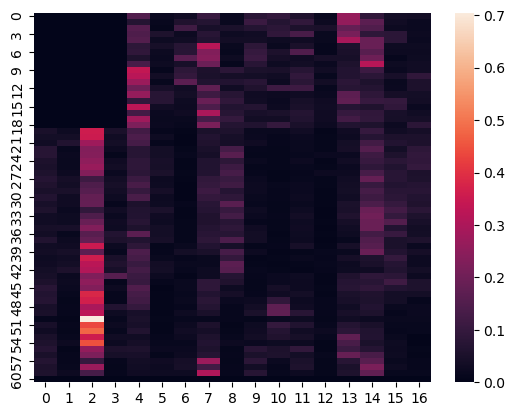

In [15]:
# Example
import sys
import os

source_folder = "/beegfs/halder/GITHUB/RESEARCH/crop-yield-forecasting-germany/src"
sys.path.append(source_folder)

from dataset.dataset import CropFusionNetDataset
import config.winter_wheat as cfg
from config.winter_wheat import model_config
from torch.utils.data import DataLoader
import seaborn as sns

train_dataset = CropFusionNetDataset(cfg, mode="train", scale=True)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=4,
)

batch = next(iter(train_loader))

model = CropFusionNet(model_config)
model.to(model_config["device"])
preds = model(batch)

# # Print the attention
sns.heatmap(preds["temporal_weights"][0][:, :, 0].cpu().detach().numpy())
plt.show()

<Axes: >

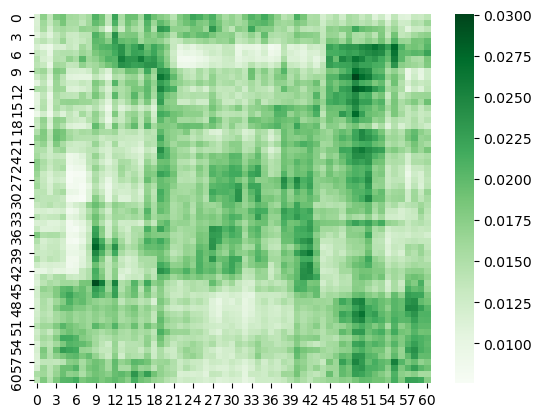

In [ ]:
sns.heatmap(preds["attention_weights"].detach().cpu().numpy()[1, :, :], cmap="Greens")

<Axes: >

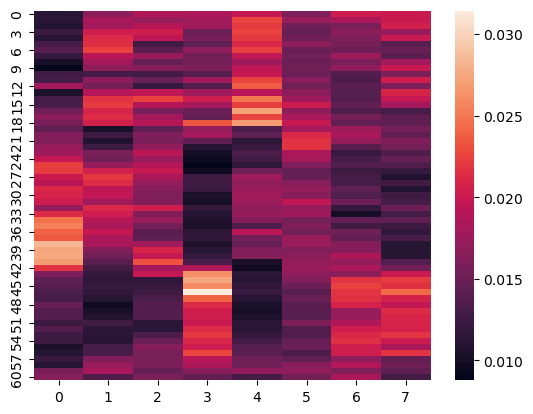

In [20]:
sns.heatmap(preds["pooled_weights"].detach().cpu().numpy()[16, :, :])

## Loss Function


In [21]:
from loss.loss import QuantileLoss

quantiles = [0.1, 0.5, 0.9]
criterion = QuantileLoss(quantiles=[0.1, 0.5, 0.9]).to(cfg.device)
criterion(preds["prediction"], batch["target"].to(cfg.device))

tensor(1.0890, device='cuda:0', grad_fn=<MeanBackward0>)